# Understanding the Relationship between World Development Indicators and GNI per Capita in Sub-Saharan African Countries

Our project seeks to understand how and if the more prosperous countries in Sub Saharan Africa can act as a model for development for the less prosperous countries. International aid has been deployed to these countries for decades, yet, the population of many countries are still stuck in a poverty trap. We believe that part of the reason for the descrepancy between the amount of aid and the level of development is due to investment in the wrong sectors. In order to mitigate this imbalance, this research seeks to understand which World Development Indicators (WDI) contribute the most to a country's increase in GNI per capita in Sub-Saharan Africa. In order to achieve this goal, we first select the most appropriate and interpretable indicators and then study the relationship between these indicators and GNI/capita fluctuation. We will observe this relationship by performing a clustering analysis for every 10 years (starting in 1980) to understand which countries have similar indicator values and how this shifts over time. The shift in cluster groups should help us understand the indicator values that countries should strive for to achieve a higher GNI per capita in the future. Additionaly, we study if the GNI/capita justifies the cluster each country is ranked in based on all other indicators. 

Note: GNI/capita is used in understanding the countries position in relation to the international poverty line 

## Table of Contents

1. Installing the Libraries

2. Retrieving the Data

3. Data Cleaning and Processing

4. Cluster Analysis

5. Conclusion

6. Future work

7. Resources

## 1. Installing the Libraries

World Bank provides an API to access all the indicators and convert them into a pandas dataframe without hassles. This API is called "wbdata". The [official documentation](https://wbdata.readthedocs.io/en/latest/) also contains the metadata for the feature labels. This can be installed by simply using the below command:

`pip install wbdata`

In [232]:
import wbdata
import geopandas as gpd
import matplotlib.pyplot as plt
import time

# library imports
import plotly
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets

## To use plotly in offline mode in jupyter notebook
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.grid_objs import Grid, Column
from plotly.tools import FigureFactory as FF

##For the gapminder bubble plot
from bubbly.bubbly import bubbleplot

##For data analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

## 2. **Retrieving the Data**

We used the `wbdata` library package to import indicators data for all Sub Saharan African countries (excluding South Sudan and Western Sahara). Some of the basic demographic information used in our analysis are GDP per capita, CPI, electricity access, CO2 emissions, imports and exports, major industries, agricultural area, population, fertility and mortality rate, urban/rural population. We then conducted preliminary exploratory analysis to understand trends qualitativelity and quantitatively. 

## 3. a. Data Preparation

In order to prepare the data for exploratory anlalysis, the country names and codes first need to be standardized according to the wbdata standards. Since both the datasets used were flexible, cleaning and processing the data did not consume a lot of time.

In [2]:
filename = "Africa_SHP/Africa.shp"
afr = gpd.read_file(filename)

#Cleaning afr dataset by standardizing country names and codes across wbdata and afr
afr = afr.replace('ZAI', 'DRC')
afr = afr.replace('CDI', 'CIV')
afr = afr.replace('CNG', 'COG')
afr = afr.replace({'Democratic Republic of Congo': 'Congo, Dem. Rep.'})
afr = afr.replace({'Congo-Brazzaville': 'Congo, Rep.'})
afr = afr.replace({'Cote d`Ivoire': "Ivory Coast"})
afr.COUNTRY = afr.COUNTRY.replace("Swaziland", "Eswatini")

In [60]:
#Excluded Reunion and Western Sahara and included South Sudan
countries = ["AGO", "BEN", "BWA", "BFA", "BDI", "CMR", "CPV", "CAF", "TCD", "COM", "ZAR", "COG", "CIV", "DJI", "GNQ", "ERI", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE", "SOM", "ZAF", "SDN", "SSD", "SWZ", "TZA", "TGO", "UGA", "ZMB", "ZWE"]

indicators = {'EN.POP.DNST': 'pop_den',
              'NY.GNP.PCAP.KD': 'GNI/capita',
              'SP.POP.TOTL':'tot_pop',
              'SP.DYN.LE00.IN': 'life_exp',
              'SP.DYN.TFRT.IN': 'fert_rate',
              'SP.ADO.TFRT': 'fert_rate_adol',
              'SP.URB.GROW': 'urb_pop_growth',
              'EN.ATM.CO2E.PC': 'emissions',
              'NY.GDP.MKTP.KD.ZG': 'gdp_growth',
              'NV.AGR.TOTL.KD': 'agr_const_usd',
              'NV.IND.TOTL.KD': 'ind_gdp_pct',
              'NE.EXP.GNFS.KD': 'export',
              'NE.IMP.GNFS.KD': 'import',
              'SP.POP.DPND': 'work_pop_age',
              'AG.LND.AGRI.ZS': 'agr_area',
              'AG.LND.ARBL.ZS': 'arable_area',
              'SP.DYN.CBRT.IN': 'birth_rate',
              'FP.CPI.TOTL': 'cpi',
              'SP.DYN.CDRT.IN': 'death_rate', 
              'NY.GDP.PCAP.KD': 'gdp_pc', 
              'NV.IND.MANF.KD': 'manf_const_usd', 
              'SP.DYN.AMRT.FE': 'mort_ad_male', 
              'SP.DYN.AMRT.MA': 'mort_ad_fe',   
              'FR.INR.RINR': 'interest', 
              'SP.RUR.TOTL.ZS': 'rural_pop', 
              'NV.SRV.TOTL.KD': 'val_add_ser', 
              'SP.URB.TOTL.IN.ZS': 'urb_pop',
              'EG.ELC.ACCS.ZS':'elec_acc'}


#Make a dataframe from the chosen indicator
wb_master_data = wbdata.get_dataframe(indicators, country=countries, convert_date=False)
gdp_line = wb_master_data.unstack(level = 0)

In [192]:
#Join the two dataframes by the country name. Reset index is done because we do not want country name and date to be considered as the 
#index of the dataframe.
wb_master_data = wb_master_data.reset_index()
wb_master_data = wb_master_data.rename(columns={"country": "COUNTRY"})
wb_master_data = wb_master_data.rename(columns={"date": "year"})
wb_master_data = wb_master_data.replace({"Cote d'Ivoire": "Ivory Coast"})

#We use the data only until 2018 because that is complete
wb_master_data = wb_master_data[wb_master_data['year'] != '2019']

#Standardizing the country name Cote d'Ivoire to be consistent for both datasets.
wb_master_data = wb_master_data.replace({"Cote d'Ivoire": "Ivory Coast"})

## 3. b. Exploratory Data Analysis

The first step of the project is to study GDP per capita in all sub-Saharan African countries from 1960 to 2018. Two types of plots are created for this analysis. Visualization using `plotly` is useful to see if there is similarity between countries, helping us determine the algorithm we use to further analyse these countries. It also helps us narrow down countries that are consistently doing well economically. We then study trends of important population, health, economic and agricultural indicators country-wise. 

Since there are 49 countries and several economic indicators, the data from The World Bank is incomplete. There are many NaN values and if we remove them from the data, we would be left with few values making it a challenge to generalize any observations. Hence, we decided to interpolate the data to produce a complete dataset. To keep the analysis simple, we used linear interpolation.

In [293]:
gdp_df = afr.merge(wb_master_data, on = "COUNTRY")
gdp_df = gdp_df.drop_duplicates(subset = ["COUNTRY", "year"], keep = "first", inplace = False)

In [294]:
#For building the africa gdp map.
#Reference : https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
data_slider = []

for year in sorted(gdp_df.year.unique()):

    gdp_df1 = gdp_df[gdp_df['year']== year]

    ### create the dictionary with the data for the current year
    data_one_year = dict(
                        type='choropleth',
                        locations = gdp_df1['COUNTRY'],
                        z=gdp_df1['GNI/capita'].astype(float),
                        locationmode='country names',
                        colorscale = "BlueRed",
                        )
    
    data_slider.append(data_one_year)

In [295]:
steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='{}'.format(i + 1960)) # label to be displayed for each step (year)
    step['args'][1][i] = True
    steps.append(step)
sliders = [dict(active=0, pad={"t": 1}, steps=steps)]  
layout = dict(geo=dict(scope='africa',
                       projection={'type': 'equirectangular'}),
              sliders=sliders, title= dict(text='GNI per capita (in USD) for Sub Saharan Africa',
                                font = dict(family = 'sans serif',
                                  size = 24)                     
    )                       
                  )

choromap = go.Figure(data = data_slider, layout = layout)
iplot(choromap)

In [ ]:
wb_master_data = wb_master_data.interpolate(method='linear',limit_direction='both', axis=0)

## 3.c. GNI Analysis

One of our first steps in this project was to create a threshold to separate countries that have an average GNI/capita above the international poverty line from the countries below this line. In order to do this, we used [World Vision](https://www.worldvision.org/sponsorship-news-stories/global-poverty-facts) for data on the set international poverty level for years 1990, 2000, 2010 and 2018 (note that we started our analysis at 1990 because there was no set international povery line before this date). According to World Vision, the international poverty line was set in 1990, 2008 and 2015. After accounting for the time value of money, the international povery lines were as follows:
 
$$ 1990 = $1 / day $$

$$ 2000 = $1.32 / day $$

$$ 2010 = $1.40 / day $$

$$ 2018 = $2.12 / day $$

Using this information, we calculated what the respective GNI/capita by multiplying each of these values by 365 days. For example, for 1990 the GNI/capita that corresponds to the international poverty line would be: 

$$ $1 / day * 365 days = $365 $$


In [75]:
gni_columns  = [col for col in wb_master_data.columns if 'GNI/capita' in col]
gni_df = wb_master_data[gni_columns]
# Format the dataframe
gni_df_3 = gni_df.unstack(level=-1)
gni_df_3 = gni_df_3.reset_index()
gni_df_4 = gni_df_3
gni_df_4.columns = gni_df_3.columns.get_level_values(1)
gni_df_4['country'] = gni_df_4['']

# Create dataframe of countries below poverty line in 1990
gni_df_1990 = gni_df_4[['1990','country']]
gni_df_1990_poverty = gni_df_1990['1990'] < 365
gni_df_1990_poverty_d = gni_df_1990[gni_df_1990_poverty]

# Create dataframe of countries below poverty line in 2000
gni_df_2000 = gni_df_4[['2000','country']]
gni_df_2000_poverty = gni_df_2000['2000'] < 481.8
gni_df_2000_poverty_d = gni_df_2000[gni_df_2000_poverty]

# Create dataframe of countries below poverty line in 2010
gni_df_2010 = gni_df_4[['2010','country']]
gni_df_2010_poverty = gni_df_2010['2010'] < 511
gni_df_2010_poverty_d = gni_df_2010[gni_df_2010_poverty]

# Create dataframe of countries below poverty line in 2018
gni_df_2018 = gni_df_4[['2018','country']]
gni_df_2018_poverty = gni_df_2018['2018'] < 511
gni_df_2018_poverty_d = gni_df_2018[gni_df_2018_poverty]

# Merge the dataframe
gni_poverty = pd.merge(gni_df_1990_poverty_d, gni_df_2000_poverty_d, how = 'outer')
gni_poverty = pd.merge(gni_poverty, gni_df_2010_poverty_d, how = 'outer')
gni_poverty = pd.merge(gni_poverty, gni_df_2018_poverty_d, how = 'outer')

In [76]:
gni_poverty = gni_poverty.reset_index(drop=True)
gni_poverty = gni_poverty.set_index('country')

In [78]:
gni_poverty

date,1990,2000,2010,2018
country,,,,
Burkina Faso,340.987901,431.032270,NaN,NaN
Mozambique,170.381257,252.909362,417.026645,NaN
Rwanda,356.703149,328.337198,NaN,NaN
Uganda,297.862735,411.563041,NaN,NaN
Burundi,NaN,232.754157,232.990035,NaN
"Congo, Dem. Rep.",NaN,285.150047,319.914909,403.490109
Madagascar,NaN,422.411280,408.332679,NaN
Central African Republic,NaN,NaN,490.141516,NaN
Ethiopia,NaN,NaN,340.319343,NaN


The following table shows the countries with a GNI/capita that lie below the international poverty line for 1990, 2000, 2010 and 2018. The NaN values show when the country is not under the poverty line for that respective year. You will notice that Mozambique and the Democratic Republic of Congo show up in three out of the four years as having a lower GNI/capita than the international poverty line. We will study all indicators further for these two countries to see if we can understand why these two countries stay impoverished for decades.

Now that we have a dataframe with the countries considered below the international poverty line for 1990, 2000, 2010, 2018, we need to find the countries with the top GNI/capita values. We will limit this analysis to the top 5 performing countries in each of these years.

In [79]:
gni_df_1990_sort = gni_df_1990.sort_values(by=['1990'],  ascending=False)
gni_df_2000_sort = gni_df_2000.sort_values(by=['2000'],  ascending=False)
gni_df_2010_sort = gni_df_2010.sort_values(by=['2010'],  ascending=False)
gni_df_2018_sort = gni_df_2018.sort_values(by=['2018'],  ascending=False)

In [104]:
gni_df_1990_sort = gni_df_1990_sort.set_index('country')
gni_df_1990_sort.iloc[:5]

date,1990
country,
Gabon,10654.388075
South Africa,5866.450582
Botswana,4018.536184
Mauritius,3768.542279
Namibia,3570.524319


In [105]:
gni_df_2000_sort = gni_df_2000_sort.set_index('country')
gni_df_2000_sort.iloc[:5]

date,2000
country,
Gabon,8869.954436
South Africa,5811.385144
Mauritius,5635.264725
Botswana,4886.464056
Namibia,4122.117463


In [106]:
gni_df_2010_sort = gni_df_2010_sort.set_index('country')
gni_df_2010_sort.iloc[:5]

date,2010
country,
Seychelles,10200.231379
Equatorial Guinea,10140.657504
Mauritius,7927.739497
Gabon,7679.323473
South Africa,7172.317461


In [107]:
gni_df_2018_sort = gni_df_2018_sort.set_index('country')
gni_df_2018_sort.iloc[:5]

date,2018
country,
Mauritius,11414.019657
Botswana,7751.170001
South Africa,7199.794464
Namibia,5939.228115
Cabo Verde,3703.890300


For the top 3 countries, we study trends in economic indicators in detail.

In [180]:
def country_indicators(country_name):
    
    cols_no_int  = [col for col in gdp_line.columns if country_name in col]
    indicators = []
    for i in range(len(cols_no_int)):
        country_ind = gdp_line[cols_no_int[i]]
        indicators.append(country_ind)
      
    country_indicators_df = pd.DataFrame(indicators).T
    country_indicators_df_zscore = (country_indicators_df-country_indicators_df.mean())/country_indicators_df.std()

  #country_indicators_df.plot(figsize = (15,15))

    country_pop_indicators_zscore = country_indicators_df_zscore.loc[:,[('pop_den', country_name),                                       
                                                                    ('work_pop_age', country_name),
                                                                    ('urb_pop', country_name), 
                                                                    ('rural_pop', country_name)]]
    
    country_health_indicators_zscore = country_indicators_df_zscore.loc[:,[('life_exp', country_name),
                                                                    ('fert_rate', country_name),
                                                                    ('fert_rate_adol', country_name),
                                                                    ('birth_rate', country_name), 
                                                                    ('death_rate', country_name),
                                                                    ('mort_ad_male', country_name),
                                                                    ('mort_ad_fe', country_name)]]

  #country_pop_indicators_df_zscore.plot(figsize = (8,8), title = 'Population indicators (normalized)')
    
    country_econ_indicators_zscore = country_indicators_df_zscore.loc[:,[('gdp_growth', country_name),
                                                                    ('ind_gdp_pct', country_name),
                                                                    ('import', country_name),
                                                                    ('manf_const_usd', country_name),
                                                                    ('emissions', country_name),
                                                                    ('export', country_name), 
                                                                    ('cpi', country_name),
                                                                    ('GNI/capita', country_name),
                                                                    ('interest', country_name),
                                                                    ('val_add_ser', country_name)]]

  #country_econ_indicators_zscore.plot(figsize = (8,8), title = 'Economic indicators (normalized)')

    
    country_ag_indicators_zscore = country_indicators_df_zscore.loc[:,[('agr_area', country_name),
                                                                    ('agr_const_usd', country_name),
                                                                    ('arable_area', country_name)]]

  #country_ag_indicators_zscore.plot(figsize = (8,8), title = 'Agricultural indicators (normalized)')

    fig, axes = plt.subplots(nrows=2, ncols=2)

    country_pop_indicators_zscore.plot(figsize = (20,20), ax=axes[0,0], title = country_name + ' Population Indicators (normalized)' )
    country_health_indicators_zscore.plot(figsize = (20,20), ax=axes[0,1], title = country_name + ' Health Indicators (normalized)')
    country_econ_indicators_zscore.plot(figsize = (20,20), ax=axes[1,0], title = country_name + ' Economic Indicators (normalized)')
    country_ag_indicators_zscore.plot(figsize = (20,20), ax=axes[1,1],title = country_name + ' Agricultural Indicators (normalized)')


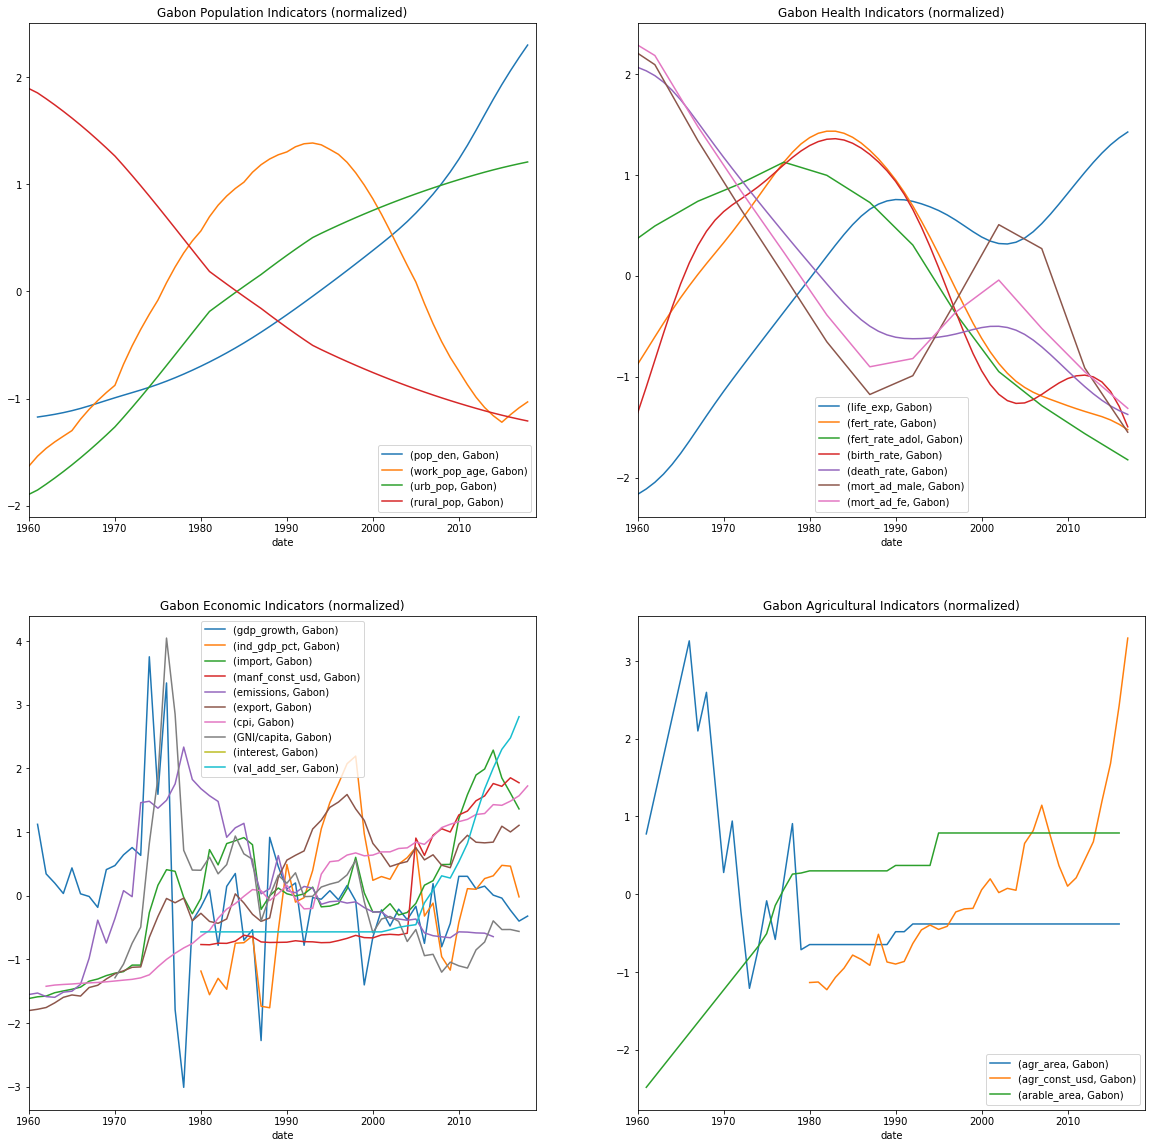

In [181]:
country_indicators('Gabon')

## Qualitative Analysis

The goal of this analysis is to understand what happens to population, health, economic and agricultural indicators with a fluctuation in GNI per capita. We will first study the countries that appear in the top 3 countries with the highest GNI per capita for the years 1990, 2000, 2010 and 2018: Gabon, Mauritius, South Africa, Mozambique and Democratic Republic of Congo. We plot each indicator subset in separate plots of each of these countries below.

## Gabon

The first interesting trend that you can see with GNI per capita is that it does not vary as much as the other economic indicators post 1990. The biggest fluctuation occurs between 2004 and 2015, where the normalized value goes from -0.4 to -1.2. Next, we will look at how the population, health, other economic and agriculture indicators react to these fluctuations.

### Population indicators: 
Between 2004 and 2015, there is a strong decrease in work age population and increase in population density. Urban population increases and rural population decreases slightly.

### Health indicators: 
This time period corresponds to a strong increase in life expectancy, strong decrease in adult mortality for both males and females and slight decrease in fertility, specifically for adolescents.

### Economic indicators: 
During this same time period, there is a decrease in industrial GDP per capita that mirrors the decrease in GNI per capita. There is a sustained strong increase in in value added service and imports with a more moderate sustained increase in CPI.

### Agricultural indictors: 
These indicators do not show anything telling during this time period.

### Historical explanation: 
In 2004, Gabon begins exporting oil and iron ore to China which we believe drive some of the indicator fluctuations.[2004](https://www.britannica.com/place/Gabon/Gabon-since-independence) was also the time in which Gabon took initiative to get rid of corruption which had diverted money meant for public works and services and part of oil revenue to public officials by privatizing state corporations. [Source](https://www.bbc.com/news/world-africa-13376514) 


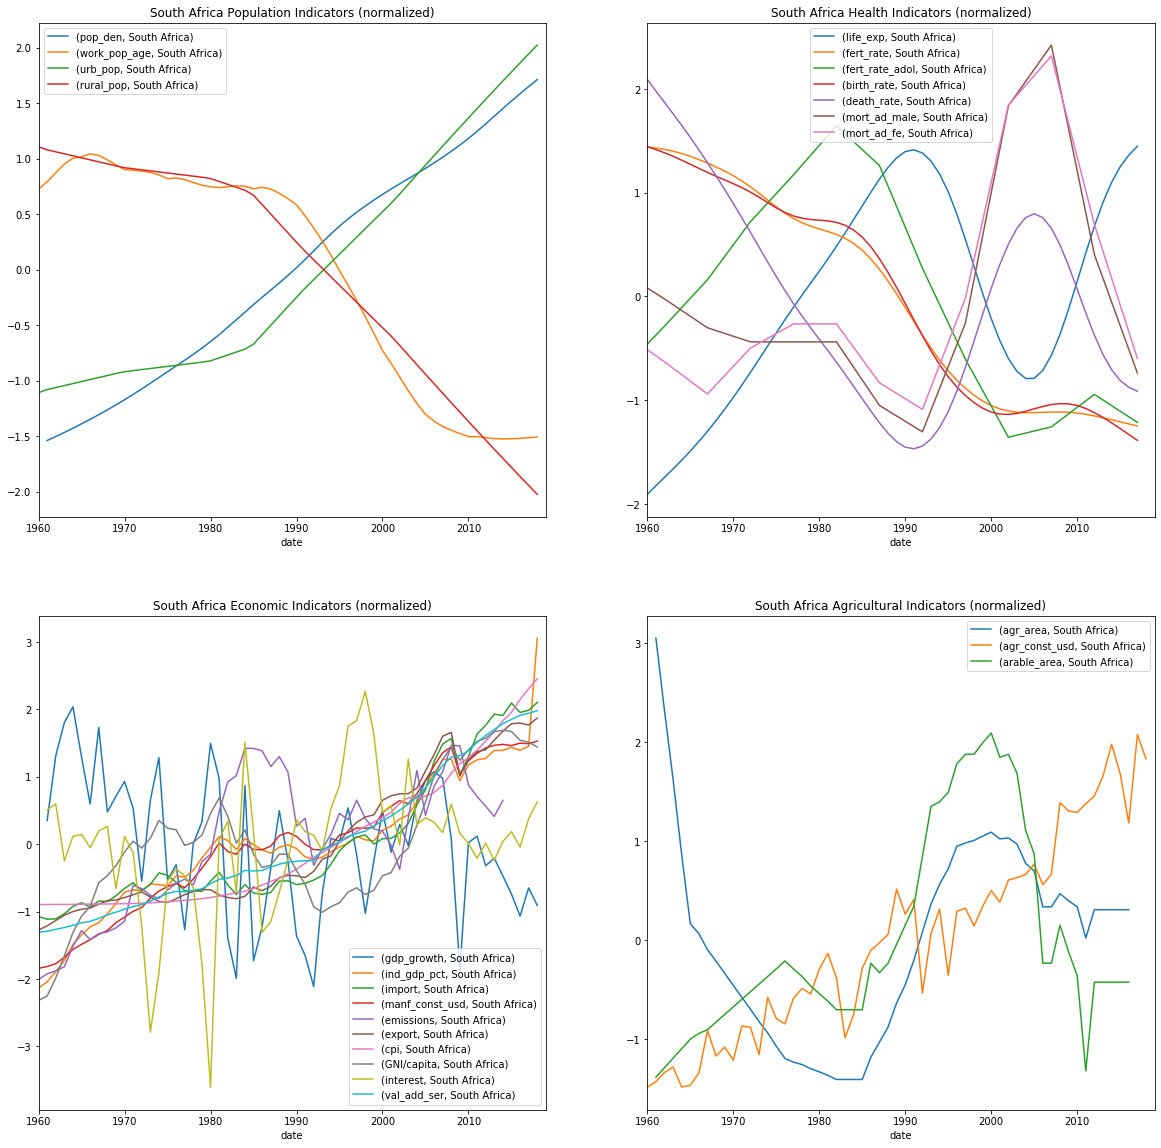

In [182]:
country_indicators('South Africa')

## South Africa

The biggest fluctuation in GNI/capita occurs between 1993 and 2008, where the normalized value goes from -1 to 1.4. 

### Population indicators: 
1993 is the exact year in which urban population exceeds the rural population indicator and when population density exceeds the working age population. From this time to 2008, work age population and rural population decrease strongly and population density and urban population increase moderately.

### Health indicators: 
In 1993, mortality rate for both male and females increases until just around 2008. 

### Economic indicators: 
Between 1993 and 2008, there is a moderate increase in exports, manufacturing, CPI and value-added services, and industrial GDP per capita that almost mirror each other exactly.

### Agricultural indictors: 
Agriculture revenue has a slow generally increasing trend between 1993 and 2008. 

### Historical explanation: 
One of the most major historical events in South Africa was apartheid, which occurred between 1948 and 1994. The end of this period was right when the GNI per capita began to increase. There were also a few policy changes that could have influenced these indicators. For example, in 2001, South Africa was able to start importing cheaper drugs into the country and it was required that pregnant women were given drugs for AIDS to avoid transmission to their babies. In 2003, there was a program that worked to tackle HIV. This could have been part of the reason that increase in mortality began to decrease around 2008, allowing the health policies a few years to show an impact. Lastly, Zuma was elected president in 2009, right when the strong increase in GNI/capita ended. [Source](https://www.bbc.com/news/world-africa-14094918)

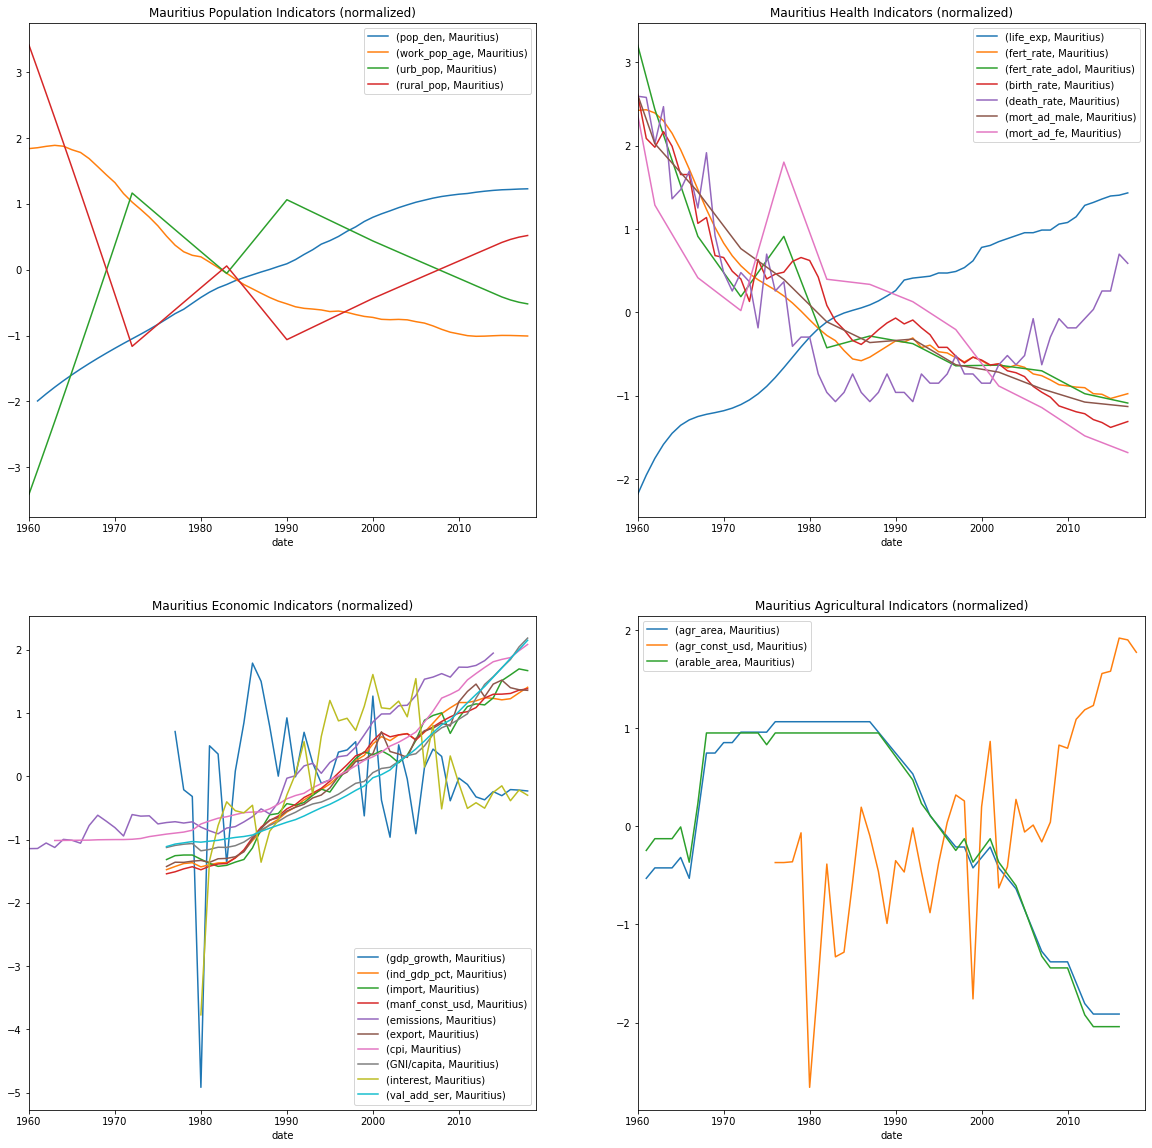

In [183]:
country_indicators('Mauritius')

## Mauritius

Mauritius is different from the other two countries in that there is a constant and steady in GNI/capita since 1990.

### Population indicators: 
1990 corresponds with a shift from an increasing urban population to decreasing and decreasing rural population to increasing.

### Health indicators: 
There are no strong fluctuations. Life expectancy and death rate both increase and the other indicators, the mortality rate for both males and females, birth rate, and fertility rate, decrease.

### Economic indicators:
Emissions, CPI, industrial revenue, exports, imports, value added services and manufacturing  all increase steadily with GNI/capita.

### Agricultural indictors: 
In 1990 is when both agricultural and arable area begin to decrease.

### Historical explanation: 
Relevant historical evens in Mauritius post 1990 include when it becomes a republic in 1992,  a new president is electric in 2002 and in 2014, the ex-president wins the parliamentary elections. [Source](https://www.bbc.com/news/world-africa-13882731)

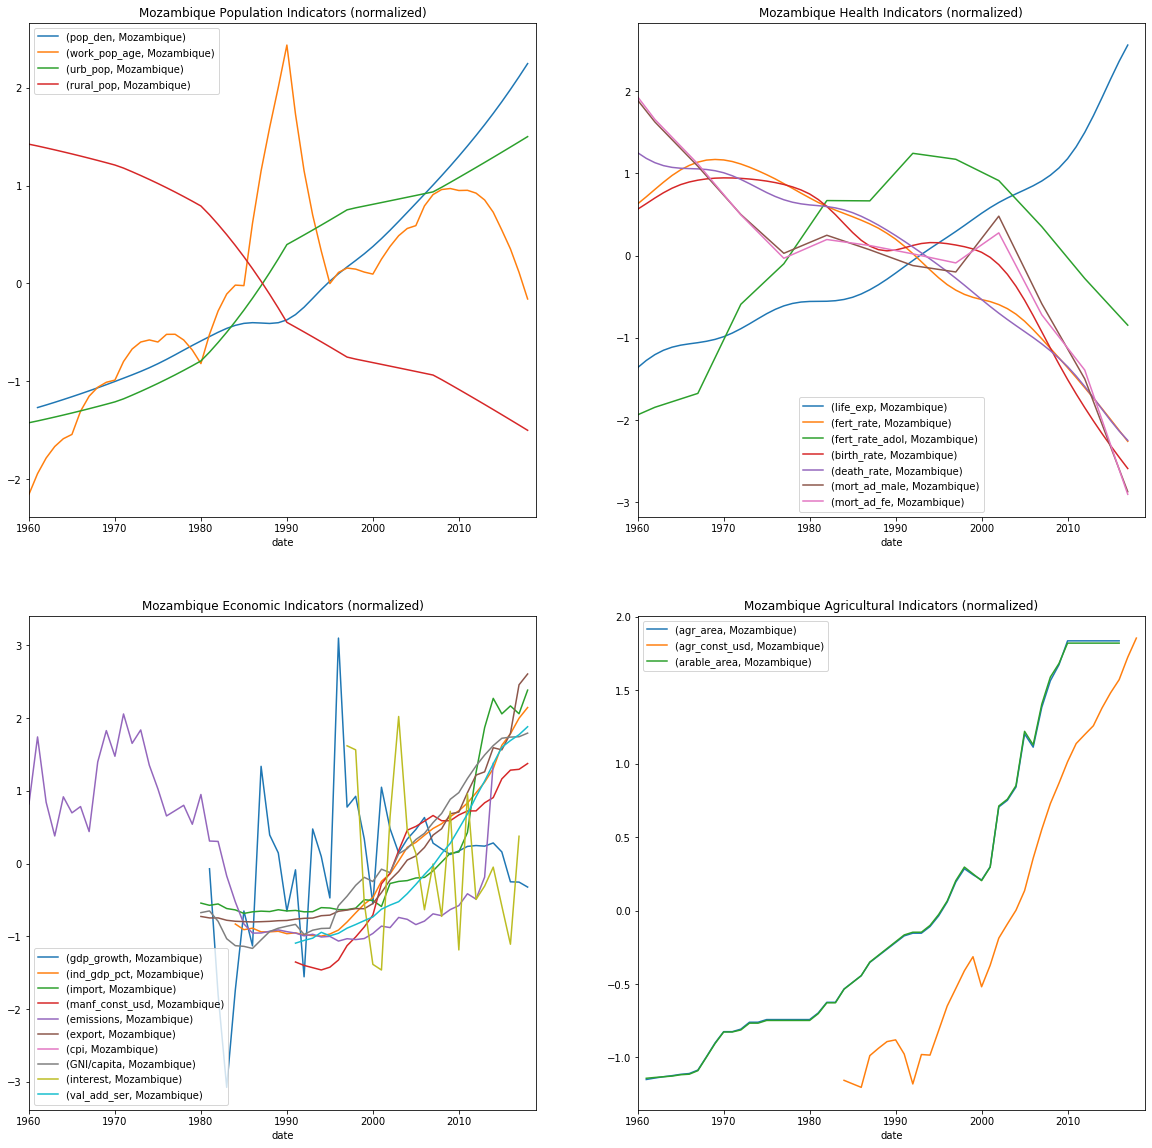

In [223]:
country_indicators('Mozambique')

## Mozambique

The GNI/capita for Mozambique lies under the poverty line in 1990, 2000, and 2010. We will study how the population, health, other economic and agricultural indicators act during these decades.

### Population: 
Theres a sharp decrease in work age population from 1990 to 1995. Population density and urban population  increases while rural population decreases.

### Health: 
Around 1992, adolescent fertility rate begins to decline from a high rate. The mortality rate for males and females, death rate and fertility rate decrease from around the same value in 1990. Life expectancy increases. 

### Economic: 
Unlike the successful countries that we have studied, the GDP growth rate in Mozambique fluctuates from a high value of 3 to -1.5, the largest range we see out of all the countries so far. Additionally, the interest rate fluctuates between 2 and -1.5 which is also the largest range we have seen out of the time periods and countries studied. Other indicators, such as imports, exports, ind_gdp_pct (DEFINE) and manf_const_usd (DEFINE) all increase at a similar rate. Emissions steadily increase from 1990 to 2010, when there is a huge spike.

### Agriculture: 
There is nothing telling from these indicators.

### Historical explanation: 
In the late 1980s/ early 1990s, the president is killed,  a new president is elected and the Soviet power collapses. There was a civil war between 1977 and 1992  and 1994 was the first year of [multiparty elections](https://en.wikipedia.org/wiki/Mozambique). In 2005 there is another new president and in 2006, The World Bank cancels Mozambique debt. [Source](https://www.bbc.com/news/world-africa-13890720).

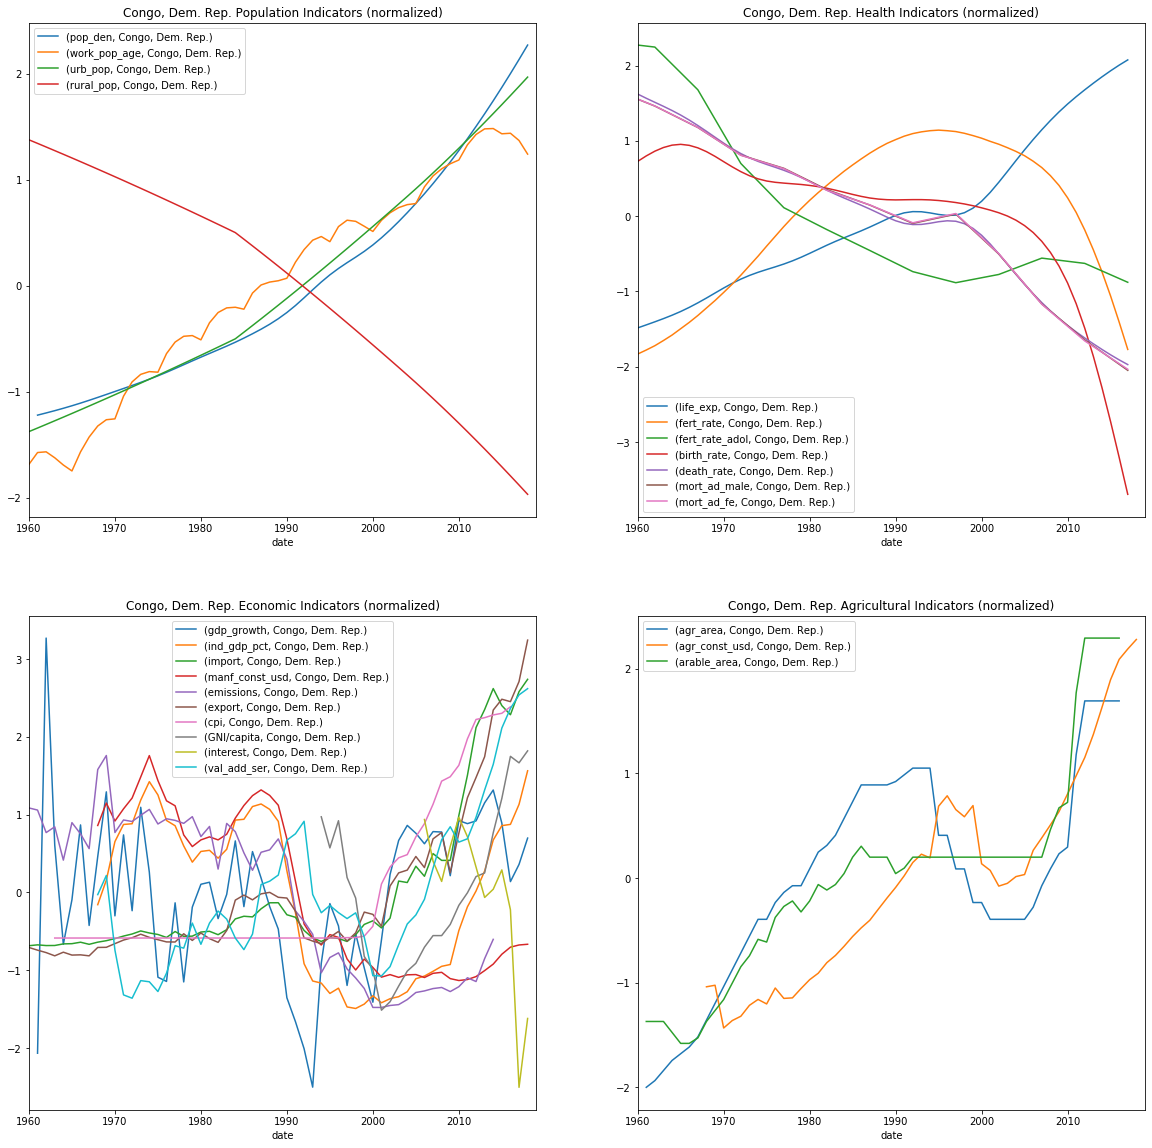

In [224]:
country_indicators('Congo, Dem. Rep.')

## Democratic Republic of Congo (DRC)

In DRC, data is available for GNI/capita starting in 1994. The value decreases strongly until 2001, when it starts to increase until 2018. 

### Population: 
Around 1993 is when the population density and urban population surpasses the rural population and increases steadily. During this time, the work age population generally increases but at a slower rate.

### Health: 
1993 is the same year as the peak of the fertility rate as well as when life expectancy increases, birth rate decreases, mortality rate decreases. The adolescent fertility rate remains relatively constant. However, the most interesting observations we make here is when GNI/capita is sharply decreasing between 1994 - 2001, there is no significant change in the educators. After 2001 is when the rate of change for these indicators begins to become more significant.

### Economic: 
Value added services seems to mirror the decrease and increase trend in GNI/capita. This is also true to a slightly lesser extent for industrial revenue, imports, exports and emissions.

### Agriculture: 
Between 1994 and 2001, agricultural area decreases. From 2001 to 2018, all indicators increase.

### Historical explanation: 
In 1989, the country has to cancel development programs after defaulting on loans from Belgian. In the early 1990s, a coalition government is formed. In the late 1990s, the eastern part of the country is captured by the Tutsi’s, the targeted group in the Rwandan genocide. In 1997, a new president is put in power. In 1998, rebels take control and the following year a ceasefire is signed. UN troops come into the country in 2000 and the president is shot in 2001. There is a peace deal signed in 2002 and a new constitution is implemented in 2006 and there is the first free elections. The major ebola outbreak begins in 2007. In 2010, The World Bank and IMF relieve the country of 8 billion USD in debt. A few years later, there are more peacekeeping efforts. In 2017, DRC is named the worst affected country from conflict replacement. [Source](https://www.bbc.com/news/world-africa-13286306)

## 4. Clustering Analysis

Clustering is a form of unsupervised learning technique. Segmentation of countries based on similar characteristics can yield useful information and identify homogenous group of countries. Analyzing individual countries can only help us identify the possible reasons for the trends shown above. Since there are 49 countries in sub Saharan Africa, grouping countries using clustering analysis helps identify if multiple countries were facing similar issues (such as outbreaks, war, etc.) that impacted their GDP growth.
There are two ways of performing clustering - hierarchical and non-hierarchical clustering. Kmeans clustering is a non-hierarchical clustering method. The algorithm, as shown in class, can be described as:

1. Randomly assign a cluster centroid
2. Assign data points near the centroid
3. Calculate the mean of the datapoints
4. Reassign the mean as the new centroid
5. Repeat until convergence

In order to determine the optimum number of clusters for a given dataset, we use the elbow plot. The idea here is to minimize the within cluster distance and maximize between cluster distance. The number that corresponds to the elbowing region in the plot is the optimum number of clusters used for our model. Data has been normalized using z-score in order to provide same importance to all features. 

Instead of analyzing the patterns for year-by-year or aggregating the data for all the years, we choose to study the data every ten years starting from 1980. We aggregated the data for a decade and used the median values to visualize the clusters. However, this was not very effective because it does not capture drastic changes that occured in a specific year.

In [199]:
wb_master_data = wb_master_data.interpolate(method='linear', limit_direction='both', axis=0)

In [234]:
def elbow_plot(data, model = KMeans):
    data = data.drop(['year','COUNTRY', 'tot_pop', 'GNI/capita'], axis =1)
    x = StandardScaler().fit_transform(data)
    distortions = []
    for i in range(1, 15):
        km = KMeans(
            n_clusters=i,
            n_init=500, max_iter=1000,
            tol=1e-04, random_state=0
        )
        km.fit(x)
        distortions.append(km.inertia_)
     # plot
    plt.plot(range(1, 15), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()  
    return None

In [235]:
def kmeans_al(num_cluster, data, KMeans, year_clus):
    data_1 = data.drop(['year','COUNTRY', 'tot_pop', 'GNI/capita'], axis =1)
    x = StandardScaler().fit_transform(data_1)
    km = KMeans(
    n_clusters=num_cluster,
    n_init=500, max_iter=1000, 
    tol=1e-04, random_state=0
    )
    y_km = km.fit_predict(x)
    data['cluster'] = y_km
    plot_cluster = afr.merge(data, left_on = 'COUNTRY', right_on = 'COUNTRY', how = "inner")
    # Setup figure and ax
    f, ax = plt.subplots(1, figsize=(9, 9))
    # Plot unique values choropleth including a legend and with no boundary lines
    plot_cluster.plot(column='cluster', categorical=True, legend=True, linewidth=0, ax=ax)
    # Remove axis
    ax.set_axis_off()
    # Keep axes proportionate
    plt.axis('equal')
    # Add title
    plt.title('Clustering '+ year_clus)
    # Display the map
    plt.show()
    return y_km

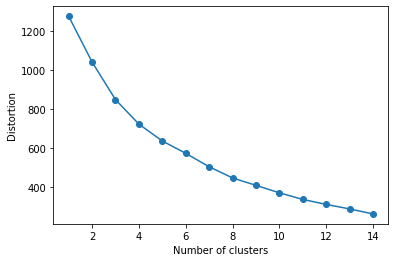

In [236]:
df_1980 = wb_master_data[(wb_master_data.year == '1980')]
elbow_plot(df_1980, model = KMeans)

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



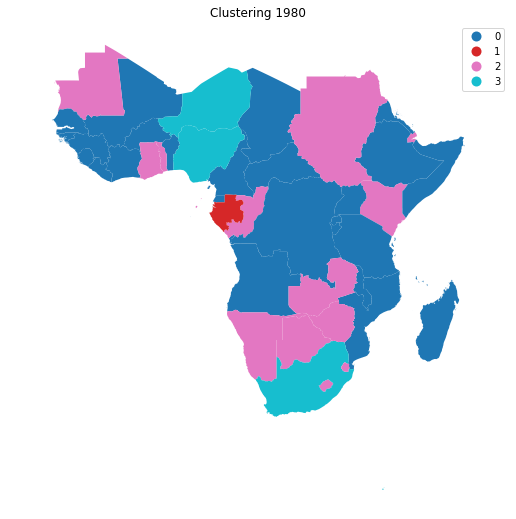

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [237]:
y_km = kmeans_al(4, df_1980, KMeans, '1980')
y_km
df_1980['cluster']= y_km

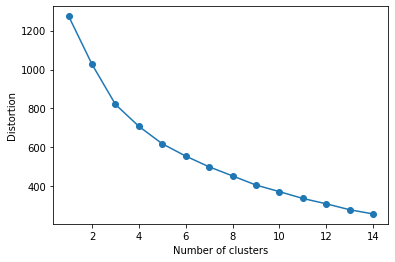

In [212]:
df_1990 = wb_master_data[(wb_master_data.year == '1990')]
elbow_plot(df_1990, model = KMeans)

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



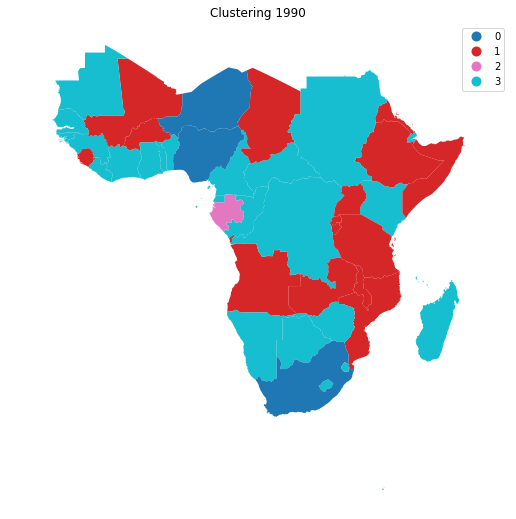

In [213]:
kmeans_al(4, df_1990, KMeans, '1990')

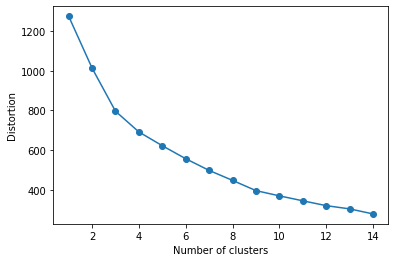

In [214]:
df_2000 = wb_master_data[(wb_master_data.year == '2000')]
elbow_plot(df_2000, model = KMeans)

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



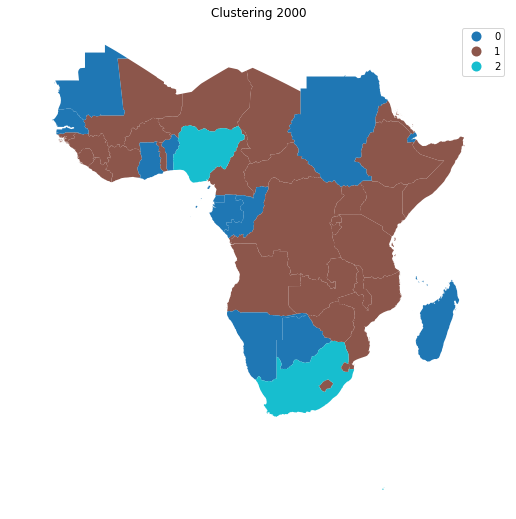

In [216]:
kmeans_al(3, df_2000, KMeans, '2000')

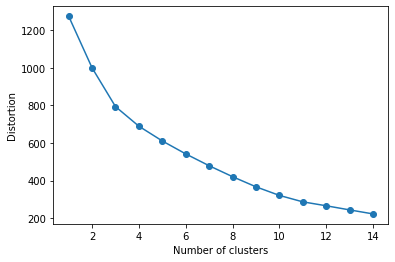

In [217]:
df_2010 = wb_master_data[(wb_master_data.year == '2010')]
elbow_plot(df_2010, model = KMeans)

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



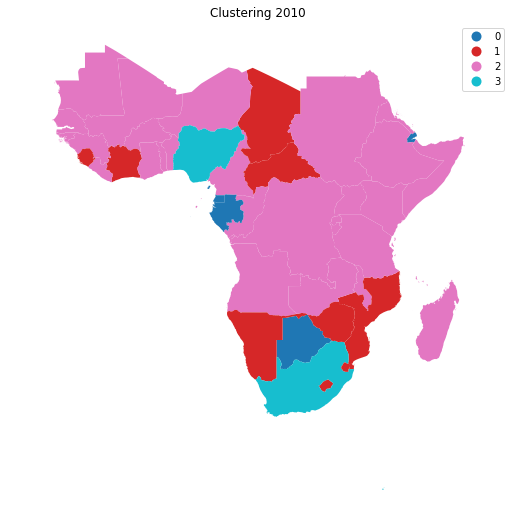

In [218]:
kmeans_al(4, df_2010, KMeans, '2010')

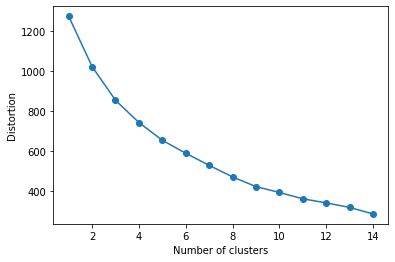

In [219]:
df_2018 = wb_master_data[(wb_master_data.year == '2018')]
elbow_plot(df_2018, model = KMeans)

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



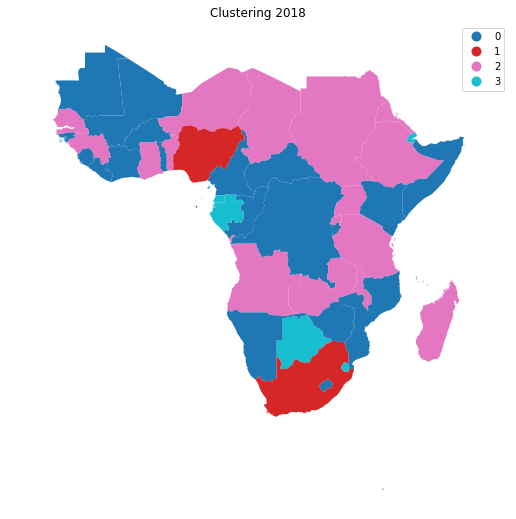

In [222]:
kmeans_al(4, df_2018, KMeans, '2018')

Few immediate observations from the clustering:

1. Most of the countries are grouped in a single cluster with few countries showing different patterns. Hence, we will take a look at these countries more closely.
2. Nigeria and South Africa are seen in the same cluster always.
3. Niger is clustered with Nigeria and South Africa and is separated after 1990. However, the analysis is inconclusive due to lack of economic indicators data prior to 1990.
4. Gabon has been identified singularly until 1990. Post 1990, it is clustered along with Botswana, Swaziland, Namibia, Djibouti and Equatorial Guinea. In this period, most of these countries were suffering from increased HIV related deaths, which could possibly explain the grouping.


## 4.a. Characterizing Clusters and GNI/capita Ranking

We find that in most cases, the ranking  each country receives (according to its cluster number) is generally well aligned with the GNI/capita value. However, there are some exceptions. For example, Botswana has the third highest GNI/capita value in 1990 but is ranked in the cluster with the 3rd (out of 4) GNI/capita value. Similarly, in 2018, Namibia has the 4th highest GNI/capita value but is ranked last. We assume that this means that Namibia was able to achieve a high GNI/capita with indicator values similar to countries that did not have a high GNI/capita. This is an interesting finding because it says that these indicators are not prescriptive for a country to escape the international poverty line.

In [271]:
cluster_gni_1980 = pd.DataFrame(df_1980.groupby(['cluster'])['GNI/capita'].mean())
cluster_gni_1980 = cluster_gni_1980.sort_values(by =['GNI/capita'])

list_des = [4, 3, 2, 1]
cluster_gni_1980['rank'] = list_des
df_1980['rank_1980'] = df_1980['cluster'].replace({0:4, 2:3, 3:2, 1:1})
df_1980.head()
#cluster_gni_1980.head()

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,COUNTRY,year,pop_den,GNI/capita,tot_pop,life_exp,fert_rate,fert_rate_adol,urb_pop_growth,emissions,...,manf_const_usd,mort_ad_male,mort_ad_fe,interest,rural_pop,val_add_ser,urb_pop,elec_acc,cluster,rank_1980
39,Angola,1980,6.690695,1023.673820,8341289.0,44.178,7.459,223.6800,8.113046,0.640966,...,1.207611e+09,415.213,481.607,-42.149939,75.702,9.756263e+09,24.298,14.774419,0,4
99,Burundi,1980,161.888551,524.667391,4157298.0,46.852,7.395,88.3624,6.365155,0.035283,...,7.883438e+08,345.654,404.999,-3.766861,95.661,2.527492e+09,4.339,21.529986,0,4
159,Benin,1980,32.965280,592.184660,3717165.0,47.190,7.025,107.4250,5.144474,0.139097,...,3.477988e+08,306.981,408.123,1.996218,72.661,9.850299e+08,27.339,19.120524,0,4
219,Burkina Faso,1980,24.937292,311.615918,6822843.0,46.049,7.127,162.9408,9.139991,0.063420,...,3.067523e+08,315.209,378.825,5.260964,91.195,8.204464e+08,8.805,27.169266,0,4
279,Botswana,1980,1.584296,2023.786713,897868.0,59.174,6.214,146.6474,10.123130,1.098628,...,9.725008e+07,228.465,289.370,-1.556655,83.521,5.413317e+08,16.479,16.727346,2,3


In [269]:
cluster_gni_1990 = pd.DataFrame(df_1990.groupby(['cluster'])['GNI/capita'].mean())
cluster_gni_1990 = cluster_gni_1990.sort_values(by =['GNI/capita'])
list_des = [4, 3, 2, 1]
cluster_gni_1990['rank'] = list_des
df_1990['rank_1990'] = df_1990['cluster'].replace({1:4, 3:3, 0:2, 2:1})
df_1990.head()

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,COUNTRY,year,pop_den,GNI/capita,tot_pop,life_exp,fert_rate,fert_rate_adol,urb_pop_growth,emissions,...,manf_const_usd,mort_ad_male,mort_ad_fe,interest,rural_pop,val_add_ser,urb_pop,elec_acc,cluster,rank_1990
29,Angola,1990,9.503799,1373.132056,11848386.0,45.306,7.272,216.6000,7.256838,0.431744,...,1.644037e+09,396.039,469.641,-70.113313,62.856,1.395566e+10,37.144,17.262791,1,4
89,Burundi,1990,211.797391,351.015864,5438957.0,47.829,7.405,83.6830,6.092262,0.038430,...,4.739805e+08,340.026,398.541,5.997142,93.729,1.446542e+09,6.271,11.735549,1,4
149,Benin,1990,44.151259,596.499437,4978496.0,53.812,6.744,125.2996,5.448743,0.142158,...,6.157027e+08,244.773,313.065,2.636114,65.515,1.198531e+09,34.485,16.232696,3,3
209,Burkina Faso,1990,32.204072,340.987901,8811034.0,49.454,7.007,146.9640,4.500103,0.066173,...,4.045343e+08,296.190,354.602,5.134202,86.185,1.273383e+09,13.815,10.962138,1,4
269,Botswana,1990,2.270492,4018.536184,1286756.0,59.191,4.485,105.9442,11.498105,2.100304,...,2.904434e+08,244.318,337.250,1.481638,58.067,1.994123e+09,41.933,10.702486,3,3


In [268]:
cluster_gni_2000 = pd.DataFrame(df_2000.groupby(['cluster'])['GNI/capita'].mean())
cluster_gni_2000 = cluster_gni_2000.sort_values(by =['GNI/capita'])
list_des = [3, 2, 1]
cluster_gni_2000['rank'] = list_des
df_2000['rank_2000'] = df_2000['cluster'].replace({1:3, 0:2, 2:1})
df_2000.head()

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,COUNTRY,year,pop_den,GNI/capita,tot_pop,life_exp,fert_rate,fert_rate_adol,urb_pop_growth,emissions,...,manf_const_usd,mort_ad_male,mort_ad_fe,interest,rural_pop,val_add_ser,urb_pop,elec_acc,cluster,rank_2000
19,Angola,2000,13.151097,1722.590292,16395473.0,46.522,6.639,196.6992,5.681753,0.581961,...,2.080463e+09,334.646,408.217,-60.781327,49.913,1.815506e+10,50.087,19.751163,1,3
79,Burundi,2000,248.398403,232.754157,6378871.0,49.091,6.920,76.2660,4.347109,0.042540,...,2.450757e+08,328.154,381.883,-16.679198,91.754,6.658320e+08,8.246,3.097561,1,3
139,Benin,2000,60.889952,691.060179,6865951.0,55.391,5.962,118.5246,3.817022,0.232861,...,1.074918e+09,257.273,314.525,3.276010,61.667,1.839894e+09,38.333,20.704035,0,2
199,Burkina Faso,2000,42.426689,431.032270,11607942.0,50.489,6.592,139.3040,6.715564,0.089717,...,5.600457e+08,298.574,358.956,5.007440,82.156,1.874321e+09,17.844,9.191235,1,3
259,Botswana,2000,2.899677,4886.464056,1643334.0,50.629,3.304,59.1762,3.637298,2.300614,...,5.430827e+08,507.203,615.861,1.145825,46.781,4.060331e+09,53.219,27.241032,0,2


In [267]:
cluster_gni_2010 = pd.DataFrame(df_2010.groupby(['cluster'])['GNI/capita'].mean())
cluster_gni_2010 = cluster_gni_2010.sort_values(by =['GNI/capita'])
list_des = [4, 3, 2, 1]
cluster_gni_2010['rank'] = list_des
df_2010['rank_2010'] = df_2010['cluster'].replace({2:4, 1:3, 3:2, 0:1})
df_2010.head()

/Users/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,COUNTRY,year,pop_den,GNI/capita,tot_pop,life_exp,fert_rate,fert_rate_adol,urb_pop_growth,emissions,...,manf_const_usd,mort_ad_male,mort_ad_fe,interest,rural_pop,val_add_ser,urb_pop,elec_acc,cluster,rank_2010
9,Angola,2010,18.734456,3241.643962,23356246.0,55.350,6.194,172.9316,4.932242,1.244092,...,3.805984e+09,233.617,306.825,-6.944836,40.217,3.510111e+10,59.783,33.368420,2,4
69,Burundi,2010,337.834969,232.990035,8675602.0,57.228,6.179,62.4852,5.787417,0.024515,...,1.878880e+08,292.259,347.666,3.554157,89.358,7.508968e+08,10.642,5.300000,2,4
129,Benin,2010,81.582645,751.882048,9199259.0,59.318,5.362,101.2906,4.003677,0.553283,...,9.632993e+08,231.638,278.869,4.191270,56.907,3.113409e+09,43.093,34.200000,2,4
189,Burkina Faso,2010,57.036612,560.370320,15605217.0,57.096,5.867,121.1052,5.293940,0.125717,...,6.481282e+08,265.826,296.047,-1.584898,75.367,3.488032e+09,24.633,13.100000,2,4
249,Botswana,2010,3.506264,6158.254391,1987105.0,60.211,3.022,48.3540,4.097430,2.358419,...,8.166936e+08,300.880,423.030,2.330457,37.588,7.065795e+09,62.412,52.671165,0,1


In [266]:
cluster_gni_2018 = pd.DataFrame(df_2018.groupby(['cluster'])['GNI/capita'].mean())
cluster_gni_2018 = cluster_gni_2018.sort_values(by =['GNI/capita'])
list_des = [4, 3, 2, 1]
cluster_gni_2018['rank'] = list_des
df_2018['rank_2018'] = df_2018['cluster'].replace({0:4, 2:3, 1:2, 3:1})
df_2018.head()

,COUNTRY,year,pop_den,GNI/capita,tot_pop,life_exp,fert_rate,fert_rate_adol,urb_pop_growth,emissions,...,manf_const_usd,mort_ad_male,mort_ad_fe,interest,rural_pop,val_add_ser,urb_pop,elec_acc,cluster,rank_2018
1,Angola,2018,24.713052,3315.262515,30809762.0,60.3790,5.6000,150.5260,4.311791,1.290307,...,5.520265e+09,199.9810,273.4350,-10.506790,34.486,4.448614e+10,65.514,41.886230,2,3
61,Burundi,2018,435.178271,289.811524,11175378.0,49.2110,6.1050,128.8950,5.700086,0.089608,...,2.911165e+08,377.7865,438.3250,16.573147,86.968,9.375266e+08,13.032,9.548837,0,4
121,Benin,2018,101.853920,889.335599,11485048.0,51.2275,5.9250,88.6454,3.891347,0.271880,...,1.448507e+09,311.0375,364.9495,4.828777,52.688,4.797486e+09,47.312,42.098304,2,3
181,Burkina Faso,2018,72.191283,687.949831,19751535.0,49.0195,5.7765,95.0459,4.984160,0.085487,...,8.483900e+05,348.0590,368.9550,0.652437,70.642,5.833694e+09,29.358,25.184961,0,4
241,Botswana,2018,3.977425,7751.170001,2254126.0,51.6220,4.6005,115.3538,3.277677,0.680780,...,1.120351e+09,313.5425,396.9145,5.527164,30.554,1.139207e+10,69.446,61.204235,3,1


In [279]:
df_rank = pd.merge(df_1980, df_1990, left_on = 'COUNTRY', right_on ='COUNTRY')
df_rank = pd.merge(df_rank, df_2000,  left_on = 'COUNTRY', right_on ='COUNTRY')
df_rank = pd.merge(df_rank, df_2010,  left_on = 'COUNTRY', right_on ='COUNTRY')
df_rank = pd.merge(df_rank, df_2018,  left_on = 'COUNTRY', right_on ='COUNTRY')
col = ['COUNTRY', 'rank_1980', 'rank_1990', 'rank_2000','rank_2010','rank_2018']
df_rank = df_rank[col]
df_rank= df_rank.sort_values(['rank_1980', 'rank_1990', 'rank_2000', 'rank_2010', 'rank_2018'], ascending=[True, True, True, True,True])
df_rank

,COUNTRY,rank_1980,rank_1990,rank_2000,rank_2010,rank_2018
15,Gabon,1,1,2,1,1
28,Mauritius,1,1,2,1,1
41,Seychelles,1,1,2,1,1
32,Nigeria,2,2,1,2,2
46,South Africa,2,2,1,2,2
31,Niger,2,2,3,4,3
4,Botswana,3,3,2,1,1
11,Cabo Verde,3,3,2,1,1
12,Djibouti,3,3,2,1,1
30,Namibia,3,3,2,3,4


We find that in most cases, the ranking  each country receives (according to its cluster number) is generally well aligned with the GNI/capita value. However, there are some exceptions. For example, Botswana has the third highest GNI/capita value in 1990 but is ranked in the cluster with the 3rd (out of 4) GNI/capita value. Similarly, in 2018, Namibia has the 4th highest GNI/capita value but is ranked last. We assume that this means that Namibia was able to achieve a high GNI/capita with indicator values similar to countries that did not have a high GNI/capita. This is an interesting finding because it says that these indicators are not prescriptive for a country to escape the international poverty line.

## 5. Conclusion

In conclusion, we first studied how the GNI/capita evolves over time from 1960 to 2018. We noticed several patterns, including consistent performance, transition towards improvement and deterioration. We took this further by look at the consistantly best performers vs the worst performers in terms of GNI/capita for each decade starting in 1980. After this, in order to see similarities amongst different countries, we performed a clustering analysis for each decade to understand the movement of countries between clusters based on its corresponding rank, a metric we defined by computing the mean GNI/capita for each cluster. We compared this result with top performing countries, based on GNI/capita, that we identified previously in the report. We found that generally the clusters were indicative of the level of GNI/capita.

## 6. Future work

This was a preliminary analysis done to understand how and if our selected indicators affect GNI/capita. This can be further studied by looking deeper at individual countries to understand the effect of each indicator on GNI/capita of the country. This can even be analyzed further with regression model to see the specific impact of each indicator on the GNI/capita. Also, having higher resolution information can provide a more accurate analysis. 

## 7. Resources

See the following links for more relevant information used in this report:

1. [World Development Indicator Data](https://datacatalog.worldbank.org/dataset/world-development-indicators)

2. [wbdata](https://pypi.org/project/wbdata/)

3. [International poverty line by year](https://www.worldvision.org/sponsorship-news-stories/global-poverty-facts)

4. [KMeans Clustering using sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

5. [Historical timeline data on a country level](https://www.bbc.com/news)